# is ud208 improving nd209 conversion rate (accept to enroll)?

In [1]:
# read data from Laurel (ud208 is from Hardy, but imported into Laurel before this)
import psycopg2
import pandas as pd
import seaborn as sns
import pymc3 as pm
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
conn_laurel = psycopg2.connect("dbname='analytics' user='analytics' host='analytics.cv90snkxh2gd.us-west-2.rds.amazonaws.com' password='!TgP$Ol9Z&6QhKW0tmn9mOW5rYT2J8'")
sql = "select id,ud_208,pay\
       from (select b.id,b.applicant_id\
                   ,case when a.user_id is not null then 1 else 0 end as ud_208,a.join_time,a.leave_time\
                   ,b.nd_key,b.cohort_id,b.application_created_at\
                   ,b.submitted_at,b.cohort_notify_at,b.accepted_at,b.rejected_at,b.first_charge_created_at\
                   ,case when b.first_charge_created_at is not null then 1 else 0 end as pay\
             from applications b\
             left join test_yidong.ud208_course a on a.user_id = b.applicant_id \
             where b.nd_key = 'nd209'\
            ) as foo\
       where submitted_at is not null and accepted_at is not null"
df = pd.read_sql(sql,conn_laurel)

In [3]:
df.groupby(['ud_208','pay'])['id'].count()

ud_208  pay
0       0       467
        1       109
1       0      3141
        1      1162
Name: id, dtype: int64

In [4]:
df.groupby(['ud_208'])['id'].count()

ud_208
0     576
1    4303
Name: id, dtype: int64

In [5]:
print("hold-off group is {0}".format(576/(576+4303)))

hold-off group is 0.11805697888911662


### So, though in each cohort the holdoff group is very small, but since cohort 101 we didn't do this experiment, sum it up we have a 12% hold off group, which is not bad to continue our ab testing here.

In [6]:
n1 = df.loc[df['ud_208']==1].shape[0]
obs_v1 = df.loc[(df['ud_208']==1) & (df['pay']==1)].shape[0]

n2 = df.loc[df['ud_208']==0].shape[0]
obs_v2 = df.loc[(df['ud_208']==0) & (df['pay']==1)].shape[0]

print("{0} students accessed ud208, {1} of them paid. ({2})".format(n2,obs_v2,obs_v2/n2))
print("{0} students don't have access to ud208, {1} of them paid. ({2})".format(n1,obs_v1,obs_v1/n1))

576 students accessed ud208, 109 of them paid. (0.1892361111111111)
4303 students don't have access to ud208, 1162 of them paid. (0.2700441552405299)


In [7]:
m1 = obs_v1/n1
m2 = obs_v2/n2
sd1 = obs_v1/n1*(1-obs_v1/n1)/n1
sd2 = obs_v2/n2*(1-obs_v2/n2)/n2
print("Students accessed us208: mean is {0} and variance is {1}".format(m1,sd1))
print("Students don't have access to us208: mean is {0} and variance is {1}".format(m2,sd2))

Students accessed us208: mean is 0.2700441552405299 and variance is 4.580997198720856e-05
Students don't have access to us208: mean is 0.1892361111111111 and variance is 0.00026636424542127483


In [8]:
m = (obs_v1+obs_v2)/(n1+n2)
sd = (obs_v1+obs_v2)/(n1+n2)*(1-(obs_v1+obs_v2)/(n1+n2))/(n1+n2)
print("Pool mean: {0}; Pool variance: {1}".format(m,sd))

Pool mean: 0.2605042016806723; Pool variance: 3.9483861977328946e-05


### We can see that with or without giving ud208 access to students, the conversion rate is 26% with a very small variance.

In [9]:
# 95% CI:
g1_lower = m1-1.96*np.sqrt(sd1/n1)
g1_upper = m1+1.96*np.sqrt(sd1/n1)
g2_lower = m2-1.96*np.sqrt(sd2/n2)
g2_upper = m2+1.96*np.sqrt(sd2/n2)
print("for student accessed us208, 95% of CI conversion rate: [{0},{1}]".format(g1_lower,g1_upper))
print("for student don't have access to ud208, 95% of CI conversion rate: [{0},{1}]".format(g2_lower,g2_upper))

for student accessed us208, 95% of CI conversion rate: [0.26984192299162446,0.2702463874894353]
for student don't have access to ud208, 95% of CI conversion rate: [0.18790325645405972,0.19056896576816248]


### We can see with small variances, for students who have access to ud208, the 95% CI of conversion rate is between 26.98% and 27.02%; for students who don't have access to ud208, 95% CI of conversion rate is between 18.79% and 19.06%.

## z test

In [10]:
s = m*(1-m)*(1/n1+1/n2)
z = (m2-m1)/np.sqrt(s)
zscore = stats.norm.ppf(.95)
print("z stats is {0}; 90% z score is {1}".format(z,zscore))

z stats is -4.149644376395081; 90% z score is 1.6448536269514722


### With the |z| > 1.64, the result is significant. We are 90% confidence to reject the hypothesis, which ud208 is not impacting conversion rate.

## bayesian ab testing

### since the pool mean is around 0.3, hence I set the priors to be Beta(2,2)

In [11]:
with pm.Model() as model: # context management
    # define priors
    prior_v1 = pm.Beta('prior_v1', alpha=2, beta=2)
    prior_v2 = pm.Beta('prior_v2', alpha=2, beta=2)
    #prior_v1 = pm.Normal('prior_v1', mu=m1, sd=sd1)
    #prior_v2 = pm.Normal('prior_v2', mu=m2, sd=sd2)

    # define likelihood
    like_v1 = pm.Binomial('like_v1', n=n1, p=prior_v1, observed=obs_v1)
    like_v2 = pm.Binomial('like_v2', n=n2, p=prior_v2, observed=obs_v2)
    
    ## define metrics
    pm.Deterministic('difference', prior_v2 - prior_v1)
    pm.Deterministic('relation', (prior_v2/prior_v1) - 1)
    
    # inference
    trace = pm.sample(draws=50000, step=pm.Metropolis(), start=pm.find_MAP(), progressbar=True)

logp = -599.13, ||grad|| = 1,005.6: 100%|██████████| 11/11 [00:00<00:00, 112.03it/s]
100%|██████████| 50500/50500 [00:10<00:00, 4674.86it/s]


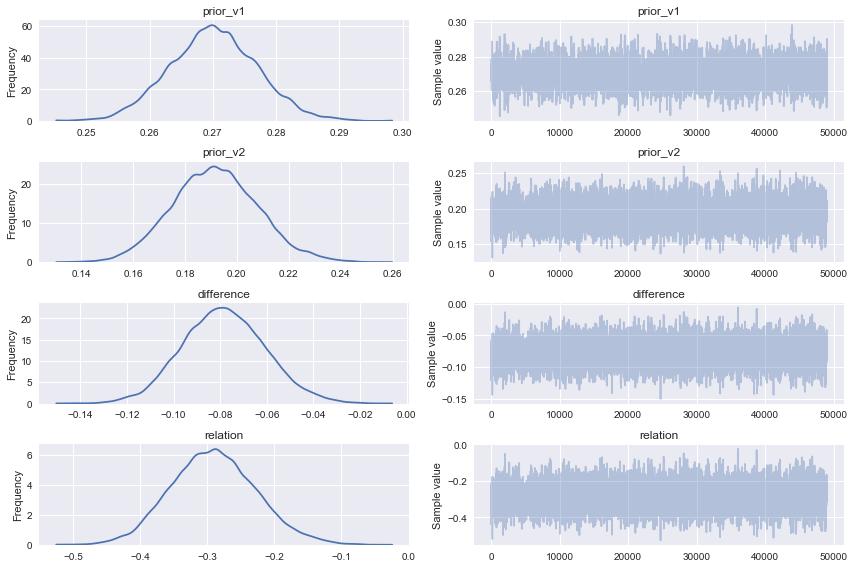

In [12]:
_ = pm.traceplot(trace[1000:], grid=True)

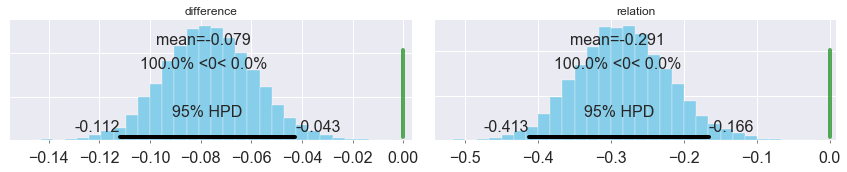

In [13]:
_ = pm.plot_posterior(trace[1000:], varnames=['difference', 'relation'], 
                      ref_val=0, color='#87ceeb')

### We can see that the differenct matric is showing: 95% CI is far from 0. Hence we concluded that we have 95% confidence to reject null hypothesis.

## To sum up, with help of z-test and bayesian ab testing, we are able to say that with 95% confidence, we cannot reject the null hypothesis, which is ud208 is not impacting conversion rate.